Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator #load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

Import dataset

In [2]:
train_dir = 'train/'
test_dir = 'test/'

In [3]:
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


Plot the number of images training set

<AxesSubplot:>

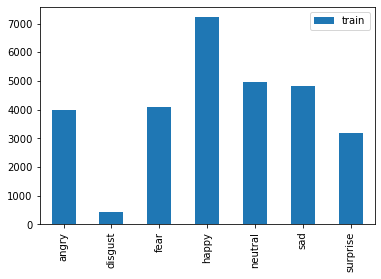

In [4]:
train_count.transpose().plot(kind='bar')

Plot the number of images of test set

<AxesSubplot:>

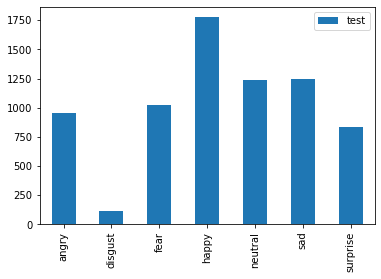

In [5]:
test_count.transpose().plot(kind='bar')

In [6]:
from keras.preprocessing import load_img
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

ImportError: cannot import name 'load_img' from 'keras.preprocessing' (C:\Users\pemaw\anaconda3\lib\site-packages\keras\preprocessing\__init__.py)

Creating training and test set

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Defining model

In [9]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [14]:
facial_model = get_model((row,col,1), classes)
facial_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

In [31]:
import pydot
from tensorflow import keras
keras.utils.plot_model(facial_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Callbacks function

In [24]:
chk_path = 'facialModel.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Training model

In [25]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = facial_model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=40,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/40
448/448 [==============================] - ETA: 0s - loss: 4.2728 - accuracy: 0.2805
Epoch 1: val_loss improved from inf to 7.86066, saving model to facialModel.h5
448/448 [==============================] - 594s 1s/step - loss: 4.2728 - accuracy: 0.2805 - val_loss: 7.8607 - val_accuracy: 0.1747 - lr: 1.0000e-04
Epoch 2/40
448/448 [==============================] - ETA: 0s - loss: 3.4888 - accuracy: 0.3373
Epoch 2: val_loss improved from 7.86066 to 3.08117, saving model to facialModel.h5
448/448 [==============================] - 560s 1s/step - loss: 3.4888 - accuracy: 0.3373 - val_loss: 3.0812 - val_accuracy: 0.4132 - lr: 1.0000e-04
Epoch 3/40
448/448 [==============================] - ETA: 0s - loss: 2.9391 - accuracy: 0.3808
Epoch 3: val_loss improved from 3.08117 to 2.64573, saving model to facialModel.h5
448/448 [==============================] - 739s 2s/step - loss: 2.9391 - accuracy: 0.3808 - val_loss: 2.6457 - val_accuracy: 0.4343 - lr: 1.0000e-04
Epoch 4/40
448/448 [

Epoch 27/40
448/448 [==============================] - ETA: 0s - loss: 0.8713 - accuracy: 0.7140
Epoch 27: val_loss improved from 1.09522 to 1.09045, saving model to facialModel.h5
448/448 [==============================] - 627s 1s/step - loss: 0.8713 - accuracy: 0.7140 - val_loss: 1.0904 - val_accuracy: 0.6384 - lr: 1.0000e-04
Epoch 28/40
448/448 [==============================] - ETA: 0s - loss: 0.8547 - accuracy: 0.7216
Epoch 28: val_loss improved from 1.09045 to 1.08107, saving model to facialModel.h5
448/448 [==============================] - 517s 1s/step - loss: 0.8547 - accuracy: 0.7216 - val_loss: 1.0811 - val_accuracy: 0.6431 - lr: 1.0000e-04
Epoch 29/40
448/448 [==============================] - ETA: 0s - loss: 0.8344 - accuracy: 0.7304
Epoch 29: val_loss did not improve from 1.08107
448/448 [==============================] - 515s 1s/step - loss: 0.8344 - accuracy: 0.7304 - val_loss: 1.0940 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 30/40
448/448 [=========================

Loss and accuracy plot

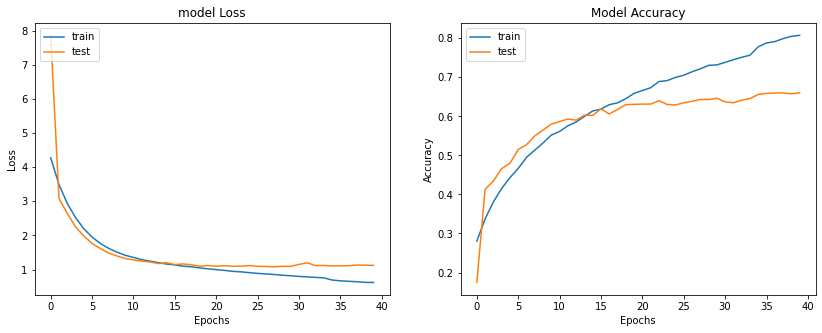

In [26]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model Evaluation

In [27]:
train_loss, train_accu = facial_model.evaluate(training_set)
test_loss, test_accu = facial_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 28s 246ms/step - loss: 1.1215 - accuracy: 0.6604
final train accuracy = 88.32 , validation accuracy = 66.04


In [28]:
facial_model.save_weights('model.h5')

Confusion matrix and Classification on training set

449/449 [==============================] - 213s 461ms/step
Confusion Matrix
[[ 525   49  513 1032  746  676  454]
 [  49    4   56  114   79   84   50]
 [ 511   65  535 1072  720  711  483]
 [ 980  103  957 1808 1292 1260  815]
 [ 669   61  691 1300  894  829  521]
 [ 666   70  635 1253  885  808  513]
 [ 424   50  406  828  501  589  373]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.13      3995
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.13      0.14      4097
       happy       0.24      0.25      0.25      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.16      0.17      0.17      4830
    surprise       0.12      0.12      0.12      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



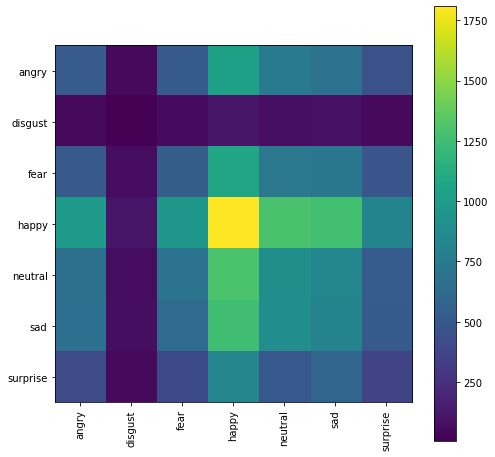

In [29]:
y_pred = facial_model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion matrix matrix and classification on test set

113/113 [==============================] - 99s 885ms/step
Confusion Matrix
[[127   4 121 245 191 175  95]
 [ 12   0  18  19  34  17  11]
 [159   9 112 229 188 201 126]
 [261  27 207 445 317 311 206]
 [179  16 152 308 207 229 142]
 [189   7 135 323 236 217 140]
 [111   5  95 220 155 141 104]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.13      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.11      0.12      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.16      0.17      0.16      1233
         sad       0.17      0.17      0.17      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



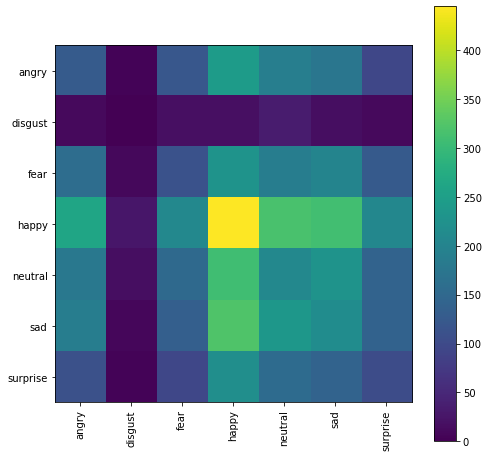

In [30]:
y_pred = facial_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)